# Construct different Hamniltonians and their Quantum Boltzmann Machines

In this brief notebook we will have a look at different Hamiltonians and their corresponding Gibbs states, aka Quantum Boltzmann Machines.

## Setup

We will use the [`quimb`](https://quimb.readthedocs.io) library to describe the states, density matrices, and Hamiltonians.
`quimb` provides some pre-defined hamiltonians for common many-body quantum systems in 1D and 2D, like the ones used in the [VQE-generated quantum circuit dataset](http://arxiv.org/abs/2302.09751) paper by Nakayama et al.

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
rng = np.random.default_rng(seed=1)

## Transverse-field ising model in 1D

### Hamiltonian

The Hamiltonian of the TFIM in 1D is constructed by starting from a _chain_ of sites connected via nearest-neighbors interactions of the spin `Z` operator, plus a term on each site corresponding to the _transverse field_ represented by the spin `X` operator

$$
H=J_{z} \sum_{\langle i, j\rangle}  Z_i Z_j  + B_x \sum_j X_j
$$

In [3]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 6

**Note** here that there are only 2 parameters in the Hamiltonian because we define the interactions and field in an isotropic way (they are the same no matter what sites we consider along the chain)

In [4]:
# define the hamiltonian given the interaction parameters
jz = rng.normal()
bx = rng.normal()
print(f"Spin interaction: {jz:.3f}")
print(f"Field value: {bx:.3f}")

Spin interaction: 0.346
Field value: 0.822


In [5]:
tfim = qu.ham_ising(n, jz, bx)

By looking at the Hamiltonian in matrix form we can see that there are off-diagonal terms due to the spin `X` operator:

In [6]:
tfim

[[ 0.43198  -0.410809 -0.410809 ...  0.        0.        0.      ]
 [-0.410809  0.259188  0.       ...  0.        0.        0.      ]
 [-0.410809  0.        0.086396 ...  0.        0.        0.      ]
 ...
 [ 0.        0.        0.       ...  0.086396  0.       -0.410809]
 [ 0.        0.        0.       ...  0.        0.259188 -0.410809]
 [ 0.        0.        0.       ... -0.410809 -0.410809  0.43198 ]]

In [40]:
tfim.shape

(64, 64)

The dimension of the Hilbert space is $2^n$

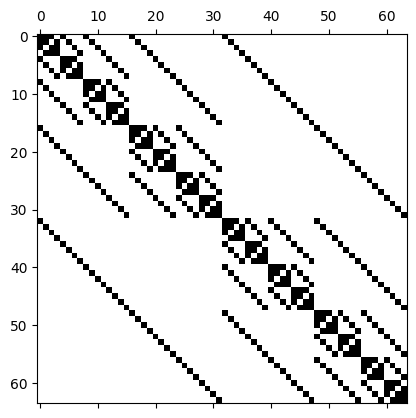

In [7]:
# in a spy plot, the non-zero entries of the matrix are black
# we can here check that the dimension of the matrix is 2^n x 2^n = 64 x 64
_ = plt.spy(tfim)

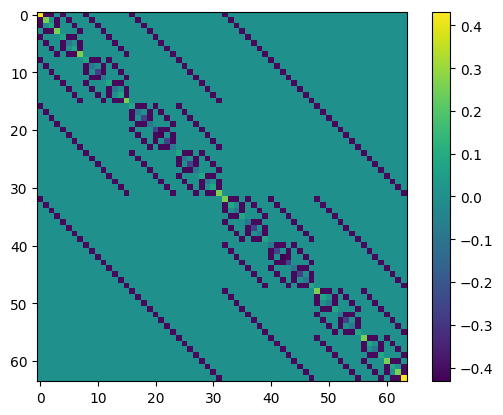

In [22]:
# a heatmap will show the different intensities on a color scale
_ = plt.imshow(tfim, interpolation='nearest')
_ = plt.colorbar()

### Gibbs state

A Quantum Boltzmann Machine is defined as the Gibbs state of a particular parameterized Hamiltonian $\mathcal{H}_\theta$ at temperature $T=1/\beta$:

$$
\rho_\theta(\beta) = \frac{e^{-\beta \mathcal{H}_\theta}}{Z} \, ,
$$

where $Z$ is the partition function $Z= \mathrm{Tr}[e^{-\beta \mathcal{H}_\theta}]$

In [8]:
# define beta=1 (since all the parameters in the hamiltonian can simply be rescaled by this number, this makes it easy)
beta = 1.0

If the Hamiltonian can be exactly diagonalized (it is not too big) then it is easy to define its exponential and the partition function.

**Note** here that the partition function involves a sum over all possible states and it becomes intractable for large systems. One would need to use approximate methods to compute the trace.

In [10]:
# do exact diagonalization (can be done on laptop up to n~16)
el, ev = qu.eigh(tfim)

In [13]:
# the numerator: using eigenvalues el and eigenvectors ev
exp_bh = ev @ np.diag(np.exp(-beta * el)) @ ev.H

In [14]:
exp_bh

[[1.114001 0.46872  0.507863 ... 0.013495 0.013118 0.004962]
 [0.46872  1.300063 0.202771 ... 0.037442 0.005248 0.013118]
 [0.507863 0.202771 1.518147 ... 0.005552 0.037442 0.013495]
 ...
 [0.013495 0.037442 0.005552 ... 1.518147 0.202771 0.507863]
 [0.013118 0.005248 0.037442 ... 0.202771 1.300063 0.46872 ]
 [0.004962 0.013118 0.013495 ... 0.507863 0.46872  1.114001]]

In [15]:
# the denominator: the partition function as the trace over the numerator
z = qu.trace(exp_bh)

The Gibbs state for the TFIM Hamiltonian is then:

In [16]:
rho_tfim = exp_bh/z

In [25]:
rho_tfim

[[1.045864e-02 4.400517e-03 4.768006e-03 ... 1.266982e-04 1.231529e-04 4.658556e-05]
 [4.400517e-03 1.220546e-02 1.903689e-03 ... 3.515210e-04 4.926778e-05 1.231529e-04]
 [4.768006e-03 1.903689e-03 1.425292e-02 ... 5.212123e-05 3.515210e-04 1.266982e-04]
 ...
 [1.266982e-04 3.515210e-04 5.212123e-05 ... 1.425292e-02 1.903689e-03 4.768006e-03]
 [1.231529e-04 4.926778e-05 3.515210e-04 ... 1.903689e-03 1.220546e-02 4.400517e-03]
 [4.658556e-05 1.231529e-04 1.266982e-04 ... 4.768006e-03 4.400517e-03 1.045864e-02]]

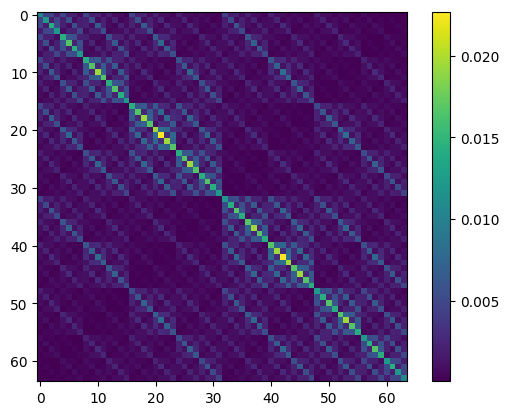

In [20]:
_ = plt.imshow(rho_tfim, interpolation='nearest')
_ = plt.colorbar()

#### Speed up

`quimb` has a convenient function for creating Gibbs (thermal) states of a given Hamiltonian. Under the hood it does what we just did above, but with improvements on speed when the number of qubits increases.

In [23]:
rho_tfim_qb = qu.thermal_state(tfim, beta, precomp_func=False)  # if precomp_func=True, it returns a fuction of beta.

In [24]:
rho_tfim_qb

[[1.045864e-02 4.400517e-03 4.768006e-03 ... 1.266982e-04 1.231529e-04 4.658556e-05]
 [4.400517e-03 1.220546e-02 1.903689e-03 ... 3.515210e-04 4.926778e-05 1.231529e-04]
 [4.768006e-03 1.903689e-03 1.425292e-02 ... 5.212123e-05 3.515210e-04 1.266982e-04]
 ...
 [1.266982e-04 3.515210e-04 5.212123e-05 ... 1.425292e-02 1.903689e-03 4.768006e-03]
 [1.231529e-04 4.926778e-05 3.515210e-04 ... 1.903689e-03 1.220546e-02 4.400517e-03]
 [4.658556e-05 1.231529e-04 1.266982e-04 ... 4.768006e-03 4.400517e-03 1.045864e-02]]

In [26]:
np.allclose(rho_tfim, rho_tfim_qb)

True

## Expectation values

One of the most common operations during the training of QBMs is the calculation of expectation values of operators with respect to the Gibbs state or a target state. `quimb` makes it easy to compute expectation values.

In [33]:
# expectation value of the spin Z operator w.r.t the Gibbs state: spin operators are Pauli/2
op = qu.spin_operator('z')
op

[[ 0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j]]

In [34]:
# e.g. with Pauli Z
opp = qu.pauli('Z')
opp

[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Now we need to lift this 1-qubit operator to the full Hilbert space of our Hamiltonian (and Gibbs state). Remember we are working in a $\mathrm{dim} = 2^n$ space

In [41]:
# dimension of our system: quimb wants to keep each 2-level subsystem dimension in a list
dims = (2,) * n

In [43]:
# spin `Z` on "site" 3
op3 = qu.ikron(op, dims, inds=[3])
assert op3.shape[0] == tfim.shape[0]

In [44]:
# expectation value
exp_val = qu.expec(rho_tfim_qb, op3)
exp_val

1.6479873021779667e-17

In [46]:
# expectation value of the full hamiltonian
exp_val = qu.expec(rho_tfim_qb, tfim)
exp_val

-0.9892285757063022